Using device: cpu
Epoch [1/10], Loss: 0.3816
Epoch [2/10], Loss: 0.1539
Epoch [3/10], Loss: 0.1091
Epoch [4/10], Loss: 0.0883
Epoch [5/10], Loss: 0.0751
Epoch [6/10], Loss: 0.0665
Epoch [7/10], Loss: 0.0603
Epoch [8/10], Loss: 0.0563
Epoch [9/10], Loss: 0.0526
Epoch [10/10], Loss: 0.0495

Test Accuracy: 98.33%
Test Error Rate: 1.67%


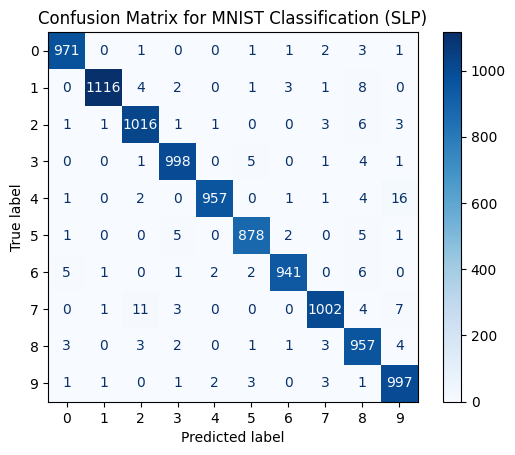

In [1]:
# SLP_MNIST_Classifier.ipynb

# Step 1: Import Necessary Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

# Step 2: Define Hyperparameters and Device
batch_size = 64
learning_rate = 0.01
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)  # For Apple Silicon Macs
print(f"Using device: {device}")
# Step 3: Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 4: Define the SLP Model (Single Linear Layer)
class SLP(nn.Module):
    def __init__(self):
        super(SLP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # self.fc = nn.Linear(28 * 28, 10)
        # Dummy forward to compute flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            x = self.pool(self.conv1(dummy_input))
            x = self.pool(self.conv2(x))
            flattened_size = x.view(1, -1).size(1)

        self.fc = nn.Linear(flattened_size, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        # Flatten the output for the fully connected layer
        # x = x.view(-1, 28*28)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SLP().to(device)

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Step 6: Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Step 7: Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
error_rate = 1 - accuracy
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Error Rate: {error_rate * 100:.2f}%")

# Step 8: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST Classification (SLP)")
plt.show()

2025-07-09 12:56:53.938604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752091014.066975  638483 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752091014.095071  638483 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752091014.279842  638483 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752091014.279885  638483 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752091014.279889  638483 computation_placer.cc:177] computation placer alr

Loading and flattening MNIST training data...


100%|██████████| 60000/60000 [00:16<00:00, 3604.57it/s]


Computing 2D UMAP embedding...


/home/rianbutala/Documents/projects/coding/cosmos/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting UMAP...


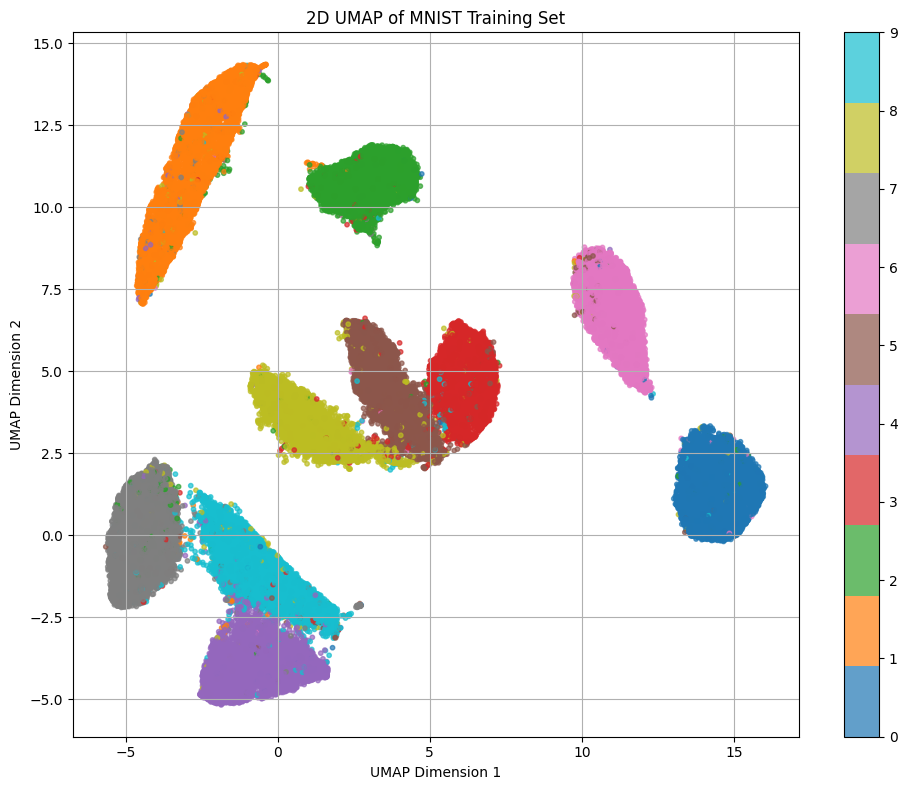

In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm

# Step 1: Load MNIST training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Step 2: Extract flattened images and labels
print("Loading and flattening MNIST training data...")
data = []
labels = []

for img, label in tqdm(mnist_train):
    data.append(img.view(-1).numpy())  # Flatten 28x28 to 784
    labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Step 3: Compute UMAP embedding
print("Computing 2D UMAP embedding...")
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Step 4: Plot the UMAP embedding
print("Plotting UMAP...")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels,
    cmap='tab10',
    s=10,
    alpha=0.7
)
plt.colorbar(scatter, ticks=range(10))
plt.title("2D UMAP of MNIST Training Set")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()